# All-pole model prior $p(x,y)$

## Model

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this.

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

The coefficients are given by "the excluded pole product":

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p) = {G \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

where the gain $G = \prod_{k=1}^K |p_k|^2$ and $\tilde{h}(x; p)$ is defined below.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

Transfer function: (Fourier transform of $h(t; p)$ with our convention)

$$ \tilde{h}(x; p) = {G \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

Note that the overall scale is determined by the DGF, so we normalize such that $h(0, p) = 1$.



## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

### PZ-model

The above paragraph assumed an AP (all-pole) model. But we could also contemplate a PZ (pole-zero) model where the amplitudes *are* free parameters (equivalent to introducing zeros, but easier because we can get a better prior and we don't have to calculate the partial fraction expansion and we have nested models for $A_k=0$).

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-11-23 00:44:55.903355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]3.1s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]16.9s, 0.3min   : Loading run_nested...
[Memory]18.4s, 0.3min   : Loading run_nested...
[Memory]19.9s, 0.3min   : Loading run_nested...
[Memory]21.3s, 0.4min   : Loading run_nested...
[Memory]21.3s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]24.9s, 0.4min   : Loading get_vtrformants_training_data...
[Memory]32.3s, 0.5min   : Loading run_nested...
[Memory]33.1s, 0.6min   : Loading run_nested...
[Memory]34.0s, 0.6min   : Loading run_nested...
[Memory]34.8s, 0.6min   : Loading run_nested...
[Memory]34.8s, 0.6min   : Loading get_vtrformants_training_data...


## Check AP power spectrum

In [2]:
prior = bandwidth.TFB_prior()

[Memory]36.9s, 0.6min   : Loading get_vtrformants_training_data...
[Memory]37.4s, 0.6min   : Loading run_nested...
[Memory]38.7s, 0.6min   : Loading run_nested...


[ 852.23482467 2681.7014054  2845.09766252]
[ 70.33565745  93.10764745 253.72773602]


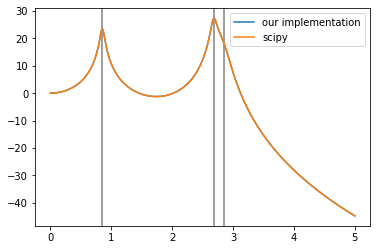

In [3]:
T, *xy = prior.sample(seed=jaxkey())
xy = np.array(xy)
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = np.linspace(0, constants.FS_KHZ/2, 500)
power = allpole.transfer_function_power_dB(f, poles)

plot(f, power, label="our implementation")
for xi in x: axvline(xi/1000, color="grey")

##
import scipy.signal

p = hstack([poles, conj(poles)])*1000
k = prod(abs(p))

w, H = scipy.signal.freqresp(([], p, k), 2*pi*f*1000)
plot(f, 20*log10(abs(H)), label="scipy")

legend();

## Peak mergers in our TFB prior

About 15% of the power spectra of of samples from the TFB prior contain merged peaks (always F1 and F2).

We can apply rejection sampling to get rid of these.

CPU times: user 23.1 s, sys: 5.39 ms, total: 23.1 s
Wall time: 23.2 s


(array([ 67.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 933.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

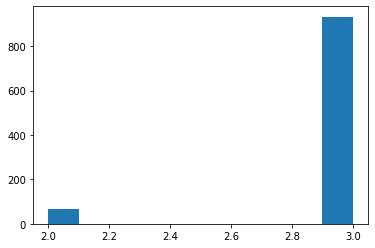

In [4]:
%%time
def sample_power_spectrum_dB(K=3, key=None):
    key = key if key is not None else jaxkey()
    f = constants.spectrum_frequencies()
    T, *xy = prior.sample(seed=key)
    xy = np.array(xy)
    x, y = np.split(xy, 2)
    x = x[:K]
    y = y[:K]
    poles = core.make_poles(y, x)
    power = allpole.transfer_function_power_dB(f/1000, poles)
    return f, x, y, power

def sample_K():
    f, x, y, power = sample_power_spectrum_dB(3, jaxkey())
    power = np.array(power)

    F, B = spectrum.get_formants_from_spectrum(
        f,
        power
    )
    
    K = len(F)
    return K

Ks = [sample_K() for _ in range(1000)]
hist(Ks)

## Try a fit

**NEED TO MEAUSRFE TILT ON A LONGER FREQEUNCY SCALE TO GET BETTER ESTIMATES!!!**

We use the same frequency range as in TIMIT (see tilt.ipynb): until 8000 Hz. This makes our tilt estimator more precise, so we adapt the sigma tilt estimator to 2+6 = 8 dB instead of 12 dB.

In [5]:
%%time
samples = allpole.get_TFB_samples()

________________________________________________________________________________
[Memory] Calling vtr.prior.allpole.get_TFB_samples...
get_TFB_samples()
[Memory]62.9s, 1.0min   : Loading get_vtrformants_training_data...
[Memory]63.3s, 1.1min   : Loading run_nested...
[Memory]63.6s, 1.1min   : Loading run_nested...


/home/marnix/WRK/thesis/py/vtr/prior/allpole.py:54: UserWarning: Rejected TFB sample that had merged peaks in its power spectrum
  warnings.warn("Rejected TFB sample that had merged peaks in its power spectrum")


__________________________________________________get_TFB_samples - 2.4s, 0.0min
CPU times: user 2.48 s, sys: 44.2 ms, total: 2.53 s
Wall time: 2.45 s


{'T': DeviceArray(5.54341993, dtype=float64),
 'F': array([ 662.81645157, 1204.52862833, 3562.82570292]),
 'B': array([ 51.95779814,  54.68078914, 118.38159027]),
 'f': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.997e+03, 7.998e+03,
        7.999e+03]),
 'power': array([ 0.00000000e+00,  2.63411511e-05,  1.05364895e-04, ...,
        -8.79909327e+01, -8.79980520e+01, -8.80051702e+01])}

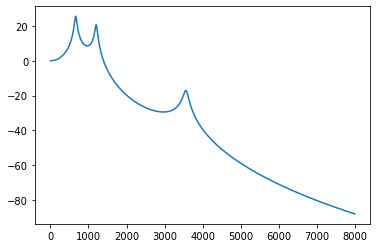

In [17]:
sample = samples[29]

plot(sample['f'], sample['power'])
sample

In [24]:
K=4
results = allpole.fit_TFB_sample(sample, K, 1111111222222)

________________________________________________________________________________
[Memory] Calling vtr.prior.allpole.run_nested...
run_nested(1111111222222, {'bootstrap': 10, 'nlive': 50, 'sample': 'rslice'}, {'maxcall': 300000, 'save_bounds': False})


1081it [06:32,  2.76it/s, +50 | bound: 62 | nc: 1 | ncall: 81814 | eff(%):  1.383 | loglstar:   -inf < -5.607 <    inf | logz: -24.168 +/-  0.450 | dlogz:  0.001 >  0.059]    

_____________________________________________________run_nested - 392.5s, 6.5min


In [16]:
fitted = allpole.get_fitted_TFB_samples()

[Memory]683.4s, 11.4min : Loading get_TFB_samples...
[Memory]683.5s, 11.4min : Loading run_nested...
3 0 -77.10027473057238
[Memory]683.5s, 11.4min : Loading run_nested...
3 1 -56.60652489888197
[Memory]683.5s, 11.4min : Loading run_nested...
3 2 -30.806233040934686
[Memory]683.5s, 11.4min : Loading run_nested...
3 3 -65.62836192137422
[Memory]683.5s, 11.4min : Loading run_nested...
3 4 -33.98217718559619
[Memory]683.5s, 11.4min : Loading run_nested...
3 5 -60.368581660728495
[Memory]683.5s, 11.4min : Loading run_nested...
3 6 -35.465362250590466
[Memory]683.5s, 11.4min : Loading run_nested...
3 7 -56.66965543401348
[Memory]683.5s, 11.4min : Loading run_nested...
3 8 -81.3531486352465
[Memory]683.5s, 11.4min : Loading run_nested...
3 9 -62.30495387492971
[Memory]683.5s, 11.4min : Loading run_nested...
3 10 -65.52921938590389
[Memory]683.5s, 11.4min : Loading run_nested...
3 11 -70.877531544076
[Memory]683.5s, 11.4min : Loading run_nested...
3 12 -62.93443911293606
[Memory]683.5s, 11.4m

In [9]:
fit = fitted[350+22]

K = fit['K']
sample = fit['sample']
results = fit['results']

def unpack(params):
    rho, h = params[:2]
    x, y = np.split(params[2:], 2)
    return rho, h, x, y

Summary
nlive: 50
niter: 1081
ncall: 81764
eff(%):  1.383
logz: -24.168 +/-  0.598


None

'Information (bans)'

6.764237905369957

Quantiles:
rho [(0.025, 0.09436230108523937), (0.5, 0.4719042489524363), (0.975, 0.9347552432715107)]
Quantiles:
h [(0.025, 1.038543584427232), (0.5, 2.1746359761223344), (0.975, 4.372856201931471)]
Quantiles:
x [(0.025, 659.1457587231935), (0.5, 662.2798126663354), (0.975, 665.7487982497239)]
Quantiles:
x [(0.025, 1195.516983000529), (0.5, 1207.582874184272), (0.975, 1217.070946595362)]
Quantiles:
x [(0.025, 1793.9434378939745), (0.5, 2709.0750404615924), (0.975, 3282.625438492541)]
Quantiles:
x [(0.025, 3511.78566155151), (0.5, 3571.2827146175764), (0.975, 3627.46918540292)]
Quantiles:
y [(0.025, 43.61662333390929), (0.5, 50.22691416348824), (0.975, 58.5321260753931)]
Quantiles:
y [(0.025, 30.923197405928214), (0.5, 49.52416045755305), (0.975, 74.2762434680807)]
Quantiles:
y [(0.025, 381.32402958284945), (0.5, 1277.901992851499), (0.975, 4533.406696546894)]
Quantiles:
y [(0.025, 49.82520670830624), (0.5, 103.56182638420334), (0.975, 196.9489161956634)]


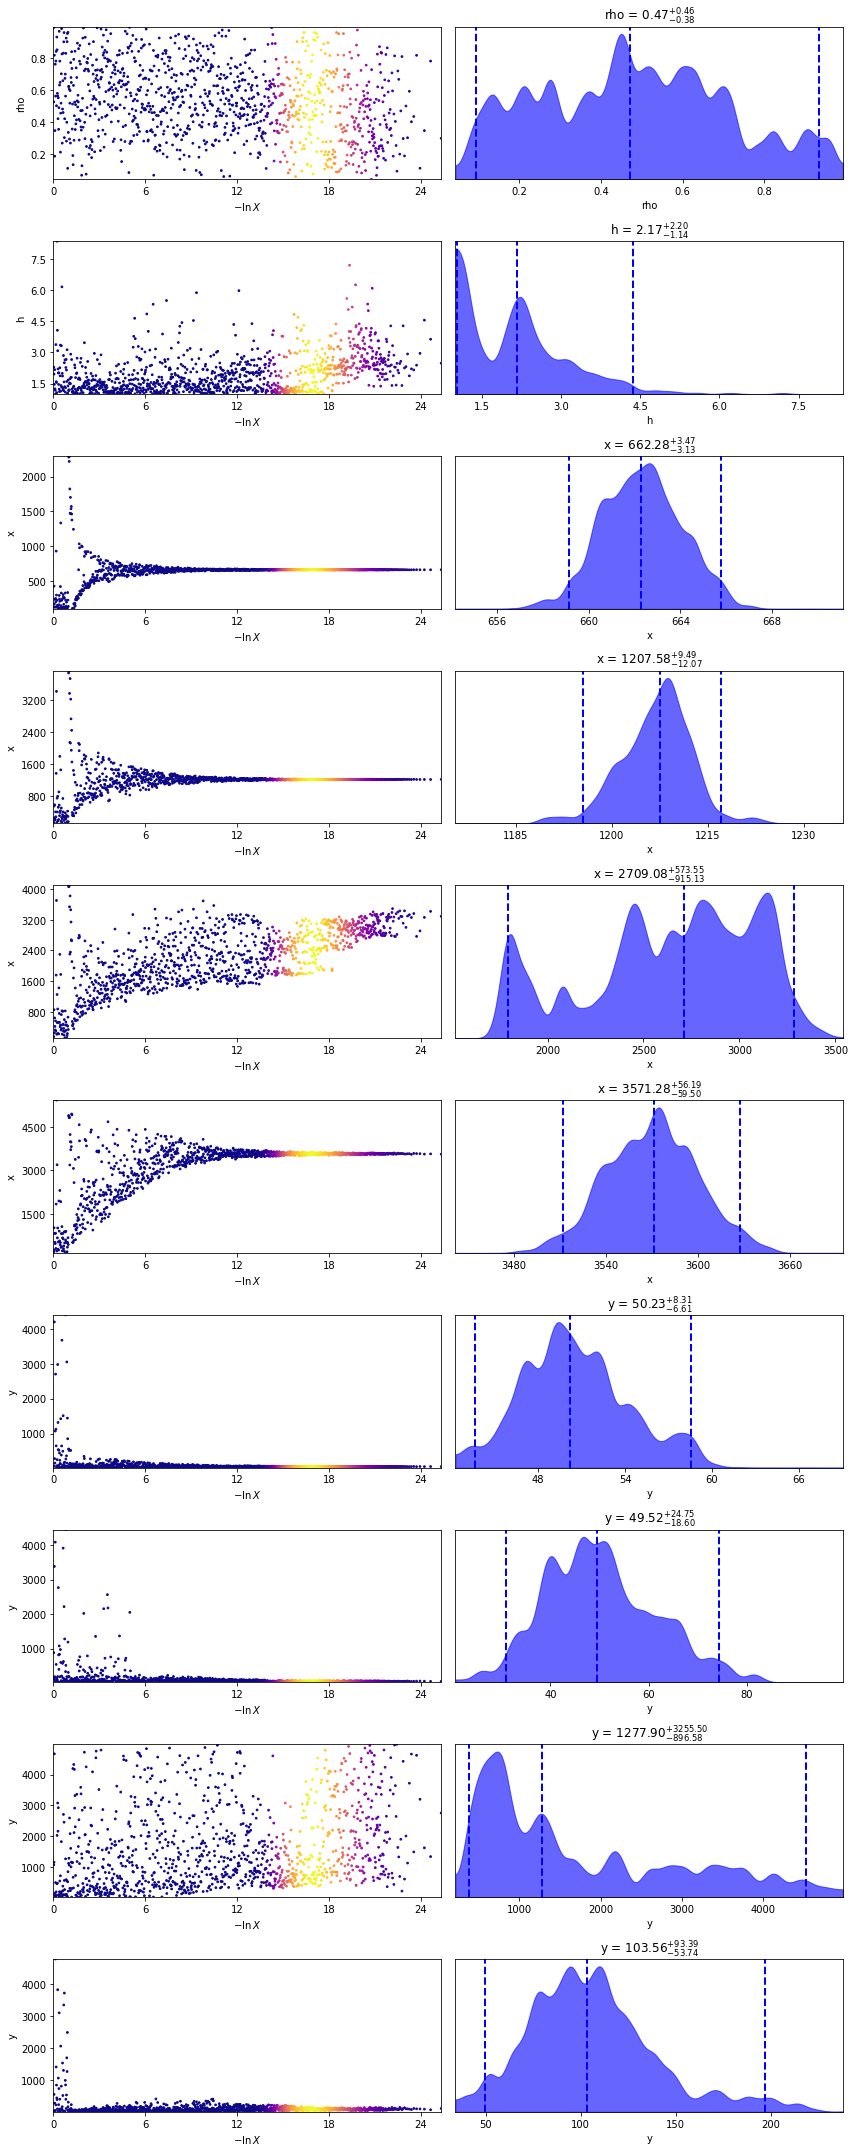

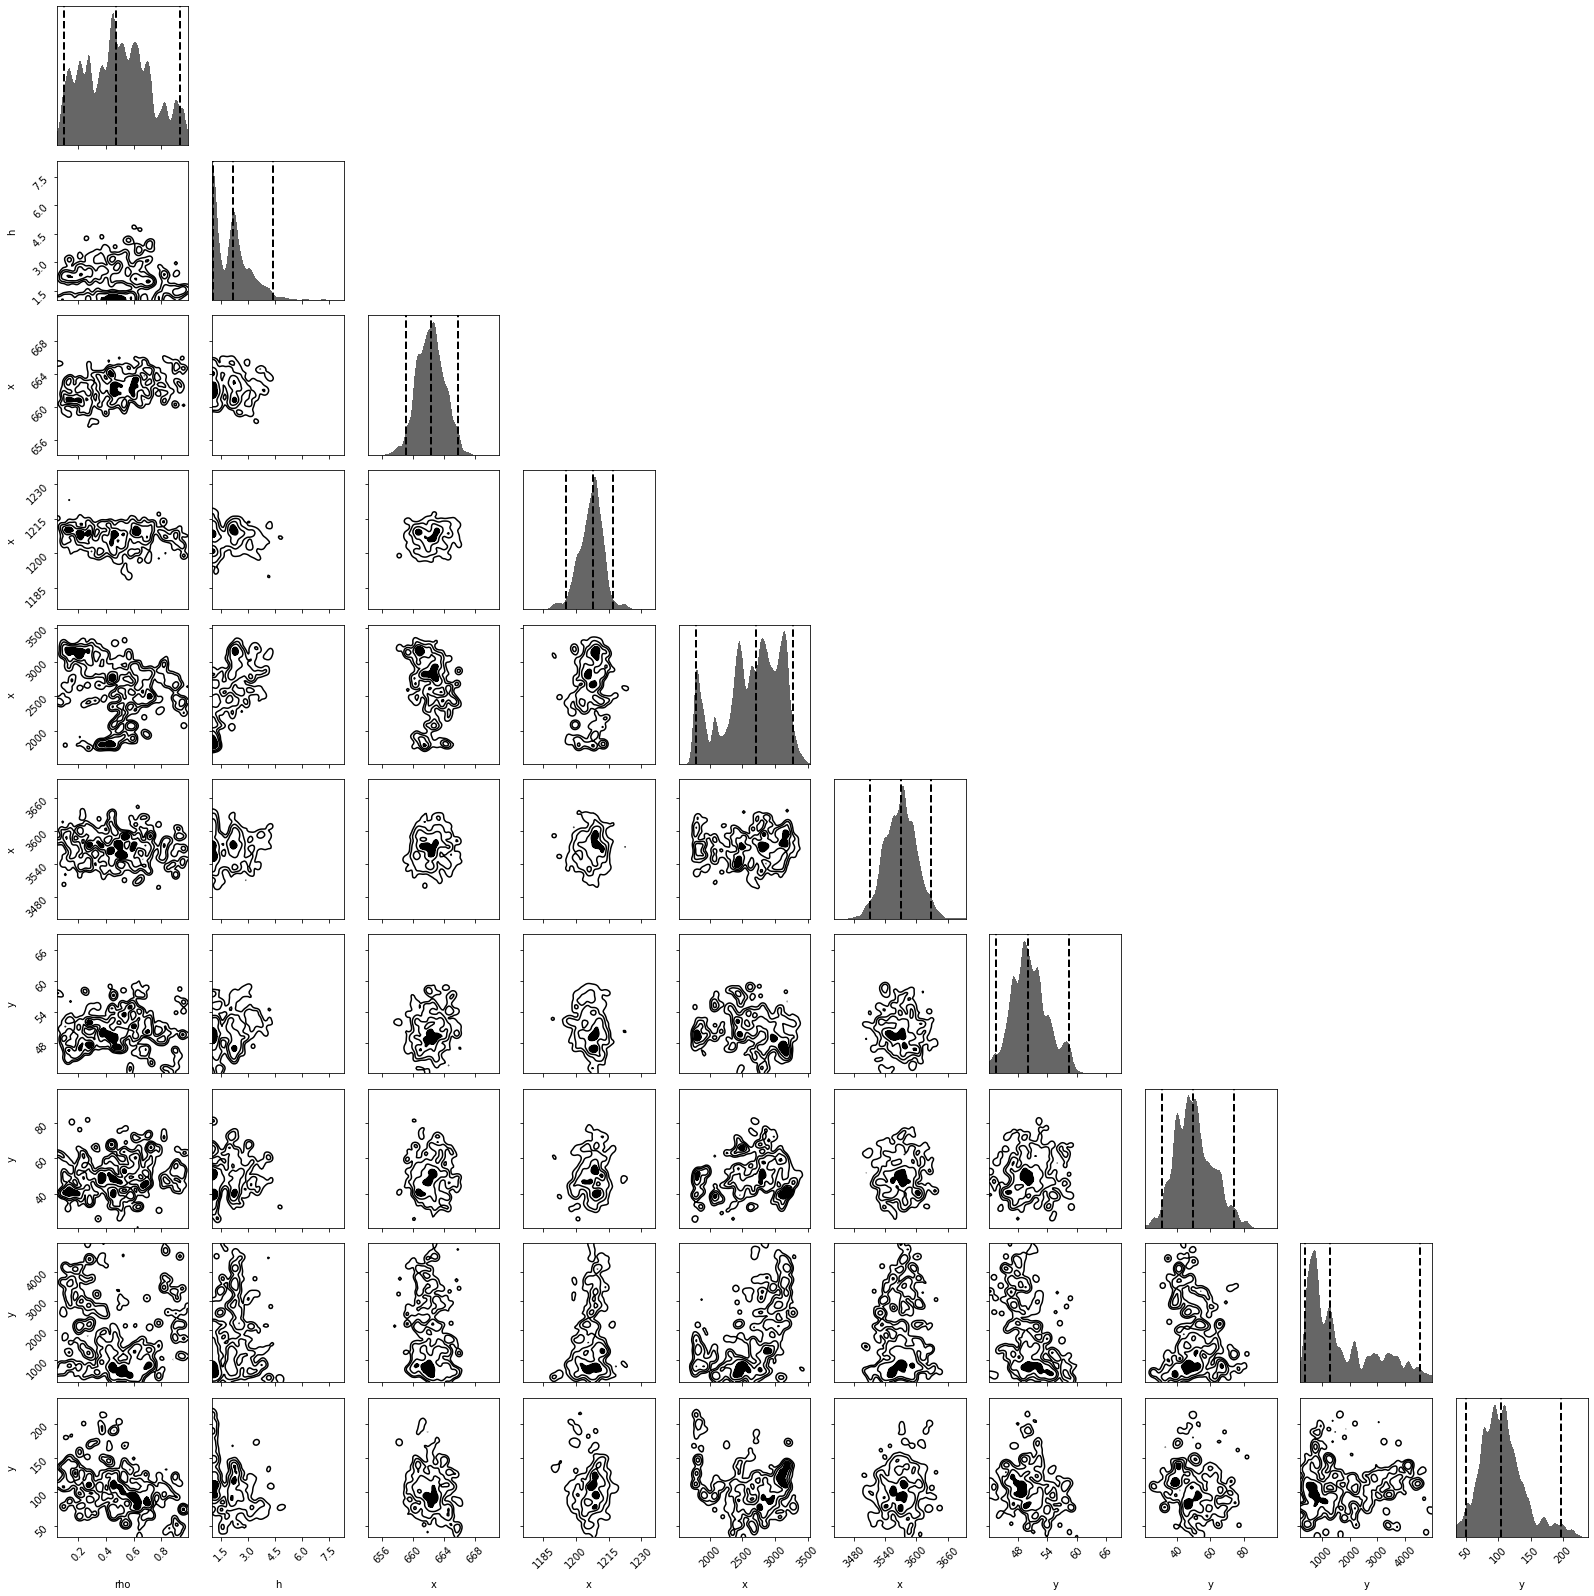

In [25]:
from lib import util

util.dyplot(results, ("rho", "h", *["x"]*K, *["y"]*K)); # (1.25, 1)

In [26]:
unpack(results.samples[-1,:])

(0.29973413244574904,
 2.482518269755907,
 array([ 663.0114624 , 1208.95619019, 3291.54791367, 3557.28405661]),
 array([  51.66596107,   51.04496264, 2752.31451726,  125.0246645 ]))

-63.97507698017464 -48.16479930623699
0.7042991630344224 2.8247794026355515 960.2275416746431
-65.1702651909722 -48.16479930623699
1.9344914053628126 1.361970919735164 997.6206010744386
-68.7184075531611 -48.16479930623699
8.262543604058257 0.5852972975977527 1112.836476607426


-560.842158754541

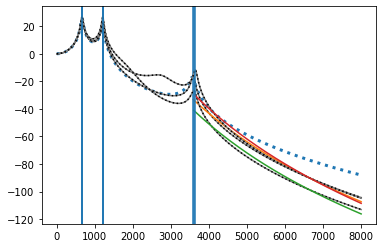

In [28]:
from vtr.prior.allpole import *

plot(sample['f'], sample['power'], ':', lw=3)

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F = np.array([2., 7, 29]),
    sigma_B = np.array([4., 14, 58]),
    tilt_target = -2,
    sigma_tilt = 2.
):
    rho, h, x, y = unpack(params)
    
    poles = core.make_poles(y, x)
    power = transfer_function_power_dB(f/1000, poles)
    
    plot(f, power, "grey")
    
    try:
        F, B, context = spectrum.get_formants_from_spectrum(
            f, power, rho, h, return_full=True
        )
    except np.linalg.LinAlgError:
        return -np.inf
    
    plot(f, context['smoothed'], ":", color="black")
    
    if len(F) != 3:
        return -np.inf
    
    Fk = F[-1]
    
    tilt, interp = spectrum.fit_tilt(f, power, cutoff=F[-1], return_interp=True)
    print(tilt, allpole.analytical_tilt(K))
    
    
    
    plot(f[f > Fk], interp(f[f > Fk]))
    
    for Fi in F: axvline(Fi)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2

    print(F_err, B_err, tilt_err)
    
    return -(F_err + B_err + tilt_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())
loglike_debug(util.resample_equal(results, 1).squeeze())

In [ ]:
from dgf import bijectors

post_samples = util.resample_equal(results, 100)[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*K + [(20., 5000.)]*K,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    post_samples, post_bounds, 1234567890000000000
)

In [ ]:
xy = b.forward(randn(2*K))
x, y = np.split(xy, 2)

print(x)
print(y)

poles = core.make_poles(y, x) # rad kHz

f = constants.spectrum_frequencies()
power = allpole.transfer_function_power_dB(f/1000, poles)



plot(f, power, label="our implementation")
ylim(None, max(power)/1.1)

F, B = spectrum.get_formants_from_spectrum(f, power)
for xi in F: axvline(xi, color="grey")


def fit_tilt2(
    f, power_spectrum, return_interp=False
):
    """Estimate tilt in dB/oct by linear regression in log domain -- see tilt.ipynb
    
    May return NaN in exceptional cases if very badly conditioned (such
    as an upwardly curving power spectrum). This is very rare.
    """
    w = (f - f[0])/(f[-1] - f[0])
    print(w)
    f2 = np.log2(f)
    f2[0] = 0.
    
    a, b = np.polyfit(f2, power_spectrum, 1, w=w**2)
    
    if return_interp:
        interp_log = np.poly1d([a, b])
        def interp(f): return interp_log(np.log2(f))
        return a, interp
    else:
        return a

def fit_tilt3(
    f, power_spectrum, return_interp=False
):
    """Estimate tilt in dB/oct by linear regression in log domain -- see tilt.ipynb
    
    May return NaN in exceptional cases if very badly conditioned (such
    as an upwardly curving power spectrum). This is very rare.
    """
    f = f[1::5]
    power_spectrum = power_spectrum[1::5]
    
    a, b = np.polyfit(np.log(f), power_spectrum, 1)
    
    if return_interp:
        interp_log = np.poly1d([a, b])
        def interp(f): return interp_log(np.log2(f))
        return a, interp
    else:
        return a

    
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]))

tilt, interp = fit_tilt2(f, power, return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]), lw=3)

tilt, interp = spectrum.fit_tilt(f, power, F[-1], return_interp=True)
print(tilt)
plot(f[300:], interp(f[300:]), lw=3)

## Aggregate

In [ ]:
def posterior_of_fitted_FBT_values(K, numsamples=100):
    def process():
        for fit in allpole.yield_fitted_TFB_samples():
            if fit['K'] == K:
                yield util.resample_equal(fit['results'], numsamples)

    return np.vstack(list(process()))

In [ ]:
Kpost = 10

post_samples = np.vstack(posterior_of_fitted_FBT_values(Kpost))

In [ ]:
import corner

fig = corner.corner(
    post_samples,
    labels=("rho", "h", *["x"]*Kpost, *["y"]*Kpost),
    show_titles=True,
    smooth=1.
);

In [ ]:
from dgf import bijectors

theta = post_samples[:,2:]

post_bounds = np.array([
    [(100., 5000.)]*Kpost + [(20., 5000.)]*Kpost,
]).squeeze()

b = bijectors.fit_nonlinear_coloring_bijector(
    theta, post_bounds, 1234567890000000
)

In [ ]:
for i in range(10):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    poles = core.make_poles(y, x) # rad kHz

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f/1000, poles)

    plot(f, power + i*30, label="our implementation")
    
    print(allpole.number_of_peaks(f, power), spectrum.fit_tilt(f, power))
    #for xi in x: axvline(xi, color="grey")

In [ ]:
rho_mean, h_mean = mean(post_samples[:,:2], axis=0)
rho_mean, h_mean, std(post_samples[:,:2], axis=0)

In [ ]:
nopeaks = []
tilts = []

for i in range(10000):
    xy = b.forward(randn(2*Kpost))
    x, y = np.split(xy, 2)

    poles = core.make_poles(y, x) # rad kHz

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f/1000, poles)
    
    F, B = spectrum.get_formants_from_spectrum(f, power, rho=rho_mean, h=h_mean)
    nopeaks += [len(F)]
    tilts += [spectrum.fit_tilt(f, power)]

hist(nopeaks, bins=50);
show()
hist(tilts, bins=50);
axvline(allpole.analytical_tilt(Kpost))